<a href="https://colab.research.google.com/github/ali-rabiee/Portfolio-Formation/blob/main/Portfolio_Formation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Requirements & Libraries

In [ ]:
!pip install gym
!pip install rl==2.4
!pip install keras-rl2
!pip install yfinance
!pip install minisom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 65 kB 2.7 MB/s 
  Created wheel for rl: filename=rl-2.4-cp37-cp37m-linux_x86_64.whl size=119957 sha256=dbe6f2c3c9f144fbee92eaca0c3dc6aae99b70301cd59c830dbba8180f94bf5e
  Stored in directory: /root/.cache/pip/wheels/7d/e5/2c/2d04071920ac0c15c22f6975db4758314002f5edc5d3366197
Successfully built rl
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 52 kB 732 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.3 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests

In [ ]:
# !pip install keras-rl
# !pip install gym
# !pip install rl==2.4
# !pip install keras-rl2
# !pip install Callbacks 
# !pip install callbacks
# !pip install rl.callbacks
# !pip install tf-nightly
# !pip install yfinance
# !pip install minisom
# !pip uninstall tensorflow --yes
# !pip uninstall keras --yes
# !pip install tensorflow==1.15
# !pip install keras==1.2.2

# Google Drive Connection

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive/', force_remount=True)
os.chdir('drive/My Drive/Colab Notebooks/DQN')

Mounted at /content/drive/


# Get Data

In [ ]:
# Name of 57 Stocks  
stocks = ['CDEV', 'GILD', 'JBLU', 'HBAN','SLB',
          'CS', 'PLUG', 'USB', 'ABBV','CTRA', 'SIRI',
          'SCHW', 'M', 'FCX', 'MO','UAL', 'ET','KGC',
          'NCLH', 'NKE','ERIC', 'ZNGA','PTON',
          'CLF', 'PYPL', 'MRO','CMCSA', 'INFY',
          'SNAP','TSM', 'CSCO', 'FB', 'UBER', 'OXY',
          'JPM', 'GOLD', 'TSLA', 'BABA', 'NLSN','TLRY',
          'AMC', 'VALE', 'DAL', 'TELL','ITUB', 'PCG','AAL',
          'NVDA', 'WFC', 'AMD', 'AAPL', 'TWTR', 'MRNA',
          'JNJ', 'GOOGL', 'COST', 'WMT']

print(f"Number of Stocks: {len(stocks)}")

Number of Stocks: 57


In [ ]:
from get_stock import get_stock

# Getting Data

start = "2020-07-10"
end = "2022-04-29"

for ticker in stocks:
    # Download datasets
    print(f'### Downloading {ticker}:')
    Hour = get_stock(ticker, start, end, "60m")
    Day = get_stock(ticker, start, end, "1d")
    Week = get_stock(ticker, start, end, "1wk")
    
    # Reset indexes
    Hour.reset_index(drop=True, inplace=True)
    Day.reset_index(drop=True, inplace=True)
    Week.reset_index(drop=True, inplace=True)

    # Save the datasets
    PATH = "datasets/"
    Hour.to_csv(f"{PATH}{ticker}hour.csv")
    Day.to_csv(f"{PATH}{ticker}day.csv")
    Week.to_csv(f"{PATH}{ticker}week.csv")
    

# DQN Model

The code needs three positional parameters to be correctly executed: \\
python main.py [numberOfActions, isOnlyShort, ensembleFolder]


* To run the FULL agent you need to run: python main.py 3 0 ensembleFolder
* To run the ONLY LONG agent you need to run: python main.py 2 0 ensembleFolder
* To run the ONLY SHORT agent you need to run: python main.py 2 1 ensembleFolder \\
where the paramenter ensembleFolder is used to set the name of the folder in which you'll get your results.

In [ ]:
"""Train the DQN Model"""

import keras
import tensorflow as tf

# This is the class call for the Agent which will perform the experiment
from deepQTrading import DeepQTrading

# Date library to manipulate time in the source code
import datetime

# Keras library to define the NN to be used
from keras.models import Sequential

# Layers used in the NN considered
from keras.layers import Dense, Activation, Flatten, Reshape, Lambda

# Activation Layers used in the source code
from keras.layers import LeakyReLU, Input

# Optimizer used in the NN
# from keras.optimizers import Adam

# Libraries used for the Agent considered
from rl.agents.dqn import DQNAgent
from rl.memory import SequentialMemory
from rl.policy import EpsGreedyQPolicy


#Library used for showing the exception in the case of error 
import sys

import pandas as pd
import numpy as np
from evaluation import perc_ensemble, full_ensemble, ensemble


'''
There are three actions possible in the stock market
Hold(id 0): do nothing.
Long(id 1): It predicts that the stock market value will raise at the end of the day. 
So, the action performed in this case is buying at the beginning of the day and sell it at the end of the day (aka long).
Short(id 2): It predicts that the stock market value will decrease at the end of the day.
So, the action that must be done is selling at the beginning of the day and buy it at the end of the day (aka short). 
//////////////////////////////////////////////////////////////
The Model is a simple NN considered. It is composed of:
One flatten layer to get 68 dimensional vectors as input
One dense layer with 35 neurons and LeakyRelu activation
One final Dense Layer with the 3 actions considered
the input is 20 observation days from the past, 8 observations from the past week and 
40 observations from the past hours
//////////////////////////////////////////////////////////////
Define the DeepQTrading class with the following parameters:
explorations: 0.2 operations are random, and 100 epochs.
in this case, epochs parameter is used because the Agent acts on daily basis, so its better to repeat the experiments several
times so, its defined that each epoch will work on the data from training, validation and testing.
trainSize: the size of the train data gotten from the dataset, we are setting 5 stock market years, or 1800 days
validationSize: the size of the validation data gotten from dataset, we are setting 6 stock market months, or 180 days
testSize: the size of the testing data gotten from dataset, we are setting 6 stock market months, or 180 days
outputFile: where the results will be written
begin: where the walks will start from. We are defining January 1st of 2010
end: where the walks will finish. We are defining February 22nd of 2019
nOutput:number of walks
'''
# Set Parameters
nb_actions = 3
isOnlyShort = 0
ensembleFolderName = "ensembleFolder"


model = Sequential()
model.add(Flatten(input_shape=(1, 1, 68)))
model.add(Dense(35,activation='linear'))
model.add(LeakyReLU(alpha=.001))
model.add(Dense(nb_actions))
model.add(Activation('linear'))


stocks = ['GOOGL']

for ticker in stocks:

    print(f"\n#### Train {ticker} ####\n")
    # Define the DeepQTrading class
    dqt = DeepQTrading(
        ticker=ticker,
        model=model,
        explorations=[(0.2, 50)],
        trainSize=datetime.timedelta(days=30*15),
        validationSize=datetime.timedelta(days=30*1),
        testSize=datetime.timedelta(days=30*1),
        outputFile="Output/csv/walks/walks",
        begin=datetime.datetime(2020, 8, 30, 0, 0, 0, 0),
        end=datetime.datetime(2022, 4, 1, 0, 0, 0, 0),
        nbActions=nb_actions,
        isOnlyShort=isOnlyShort,
        ensembleFolderName=ensembleFolderName
        )
    numWalks = dqt.run()
    dqt.end()

    # Preparing and saving the results
    numDel = 0
    for j in range(0, numWalks):

        df_test = pd.read_csv("./Output/ensemble/ensembleFolder/walk"+str(j)+f"ensemble_test_{ticker}.csv", index_col='Date')
        df_valid = pd.read_csv("./Output/ensemble/ensembleFolder/walk"+str(j)+f"ensemble_valid_{ticker}.csv", index_col='Date')

        for deleted in range(1, numDel):
            del df_test['iteration'+str(deleted)]
            del df_valid['iteration'+str(deleted)]

        if j == 0:
            fulldf_test = perc_ensemble(df_test)
            fulldf_valid = perc_ensemble(df_valid)

        else:
            fulldf_test = fulldf_test.append(perc_ensemble(df_test))
            fulldf_valid = fulldf_valid.append(perc_ensemble(df_valid))


    metrics_test = ensemble(numWalks, ticker, data_type='test', numDel=5)
    metrics_valid = ensemble(numWalks, ticker, data_type='valid', numDel=5)

    method = "short" if isOnlyShort == 1 else "long"
    method = '3act' if nb_actions == 3 else method 

    # Save Predictions
    PATH = "./Output/results/DQN predictions/"
    fulldf_test.to_csv(f"{PATH}{ticker}_{method}_preds_test.csv")
    fulldf_valid.to_csv(f"{PATH}{ticker}_{method}_preds_valid.csv")

    # Save metrics
    PATH = "./Output/results/DQN metrics/"
    metrics_test.to_csv(f"{PATH}{ticker}_{method}_metrics_test.csv")
    metrics_valid.to_csv(f"{PATH}{ticker}_{method}_metrics_valid.csv")


#### Train GOOGL ####



/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Resetted: episode 308; Index 2178 over the limit (2178)
0 TRAIN:  acc: 0.5467289719626168 cov: 0.5944444444444444 rew: 0.08522375103347395
Resetted: episode 16; Index 143 over the limit (143)
0 VALID:  acc: 0.3888888888888889 cov: 0.75 rew: -0.03704102108248907
Resetted: episode 12; Index 104 over the limit (104)
Resetted: episode 23; Index 104 over the limit (104)
0 TEST:  acc: 0.0 cov: 0.16666666666666666 rew: -0.051703577899587044
 
Resetted: episode 308; Index 2178 over the limit (2178)
1 TRAIN:  acc: 0.6763005780346821 cov: 0.48055555555555557 rew: 0.6908714314981119
Resetted: episode 16; Index 143 over the limit (143)
1 VALID:  acc: 0.7777777777777778 cov: 0.75 rew: 0.05310520326146781
Resetted: episode 12; Index 104 over the limit (104)
Resetted: episode 23; Index 104 over the limit (104)
1 TEST:  acc: 0.2 cov: 0.4166666666666667 rew: -0.09942868877456831
 
Resetted: episode 308; Index 2178 over the limit (2178)
2 TRAIN:  acc: 0.7142857142857143 cov: 0.525 rew: 0.890630450027992

In [ ]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
flatten_1 (Flatten)              (None, 68)            0           flatten_input_1[0][0]            
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 35)            2415        flatten_1[0][0]                  
____________________________________________________________________________________________________
leakyrelu_1 (LeakyReLU)          (None, 35)            0           dense_1[0][0]                    
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 3)             108         leakyrelu_1[0][0]                
___________________________________________________________________________________________

## Comparison

In [ ]:
stocks = ['CDEV', 'GILD', 'JBLU', 'HBAN','SLB',
          'CS', 'PLUG', 'USB', 'ABBV','CTRA', 'SIRI',
          'SCHW', 'M', 'FCX', 'MO','UAL', 'ET','KGC',
          'NCLH', 'NKE','ERIC', 'ZNGA','PTON',
          'CLF', 'PYPL', 'MRO','CMCSA', 'INFY',
          'SNAP','TSM', 'CSCO', 'FB', 'UBER', 'OXY',
          'JPM', 'GOLD', 'TSLA', 'BABA', 'NLSN','TLRY',
          'AMC', 'VALE', 'DAL', 'TELL','ITUB', 'PCG','AAL',
          'NVDA', 'WFC', 'AMD', 'AAPL', 'TWTR', 'MRNA',
          'JNJ', 'GOOGL', 'COST', 'WMT']

In [ ]:
import pandas as pd

# Ensemble the actions for only-long and only-short agents

data_type = 'test'

for ticker in stocks:
    # Read the predictions from gdrive 
    preds_long = pd.read_csv(f"./Output/results/DQN predictions/{ticker}_long_preds_{data_type}.csv")
    preds_short = pd.read_csv(f"./Output/results/DQN predictions/{ticker}_short_preds_{data_type}.csv")
    preds_ensemble = []

    # Number of predictions
    N = len(preds_long)

    # Ensemble the only long and only short agents predictions
    for i in range(N):
        if preds_long["ensemble"][i] == 1 and preds_short["ensemble"][i] == 0:
            preds_ensemble.append(1)
        elif preds_long["ensemble"][i] == 0 and preds_short["ensemble"][i] == 2:
            preds_ensemble.append(2)
        else:
            preds_ensemble.append(0) 

    # Create the Dataframe of ensemble predictions
    ensemble_df = preds_long.copy()
    ensemble_df['ensemble'] = preds_ensemble

    # Save 
    PATH = "./Output/results/DQN predictions/"
    ensemble_df.to_csv(f"{PATH}{ticker}_preds_ensemble_{data_type}.csv")

In [ ]:
from evaluation import ensemble

# Calculate the reward of ensemble long and short agents
method = 'ensemble'
for ticker in stocks:
    metrics_test = ensemble(numWalks=1, ticker, data_type='test', use_walks=False)
    metrics_valid = ensemble(numWalks=1, ticker=ticker, data_type='valid', use_walks=False)
    # Save metrics
    PATH = "./Output/results/DQN metrics/"
    metrics_test.to_csv(f"{PATH}{ticker}_{method}_metrics_test.csv")
    metrics_valid.to_csv(f"{PATH}{ticker}_{method}_metrics_valid.csv")

In [ ]:
# Create a csv of Rewards of all datasets with different approaches 
import pandas as pd

data_type = 'valid'
method = 'ensemble'
columns = ["Iteration", "Reward_Long%", "Reward_Short%", "Reward%", "Wins%", "Losses%", "Coverage%", "Accuracy", "Dataset"]
df_metrics = pd.DataFrame(columns=columns)
for ticker in stocks:
    metrics = pd.read_csv(f"./Output/results/DQN metrics/{ticker}_{method}_metrics_{data_type}.csv")
    metrics = metrics.loc[metrics['Iteration']=='sum'] 
    metrics['Dataset'] = ticker
    df_metrics = df_metrics.append(metrics)
    # Drop useless columns columns
    df_metrics = df_metrics.loc[:, ~df_metrics.columns.str.contains('^Unnamed')]
    df_metrics.drop(['Iteration'], axis=1, inplace=True) 
    # Reset index
    df_metrics.reset_index(drop=True, inplace=True)
    col = df_metrics.pop("Dataset")
    df_metrics.insert(0, col.name, col) 

    # Save metrics
    PATH = "./Output/results/DQN metrics/Final results/"
    df_metrics.to_csv(f"{PATH}{method}_metrics_{data_type}.csv")

In [ ]:
###############################################
#     Comparison DQN 3act with ensemble one   #
###############################################

# Regression Models

In [ ]:
import math # Mathematical functions 
import numpy as np # Fundamental package for scientific computing with Python
import pandas as pd # Additional functions for analysing and manipulating data
from datetime import date, timedelta, datetime # Date Functions
from pandas.plotting import register_matplotlib_converters # This function adds plotting functions for calender dates
import matplotlib.pyplot as plt # Important package for visualization - we use this to plot the market data
import matplotlib.dates as mdates # Formatting dates
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Reshape, Lambda
from keras.layers import LeakyReLU, Input, Dense, GRU, Dropout, LSTM, Layer, BatchNormalization
from keras import initializers, regularizers, constraints
from keras.engine.input_layer import Input
from keras import backend as K
from keras.models import Model
import time
from RegressionModels import evaluate_model, prepare_data, LSTM_model, GRU_model, LSTM_GRU_model
from get_stock import get_stock, get_reward
from feature_eng import get_indicators

In [ ]:
stocks = ['GOOGL']

In [ ]:
columns = ['Reward'] # columns that we want to predict
use_indicators = True
look_back = 7
# Do not change the start and end!
start = '2022-01-11' # START OF THE TEST DATASET
end = '2022-03-24' # END OF THE TEST DATASET
# path = f"./Output/results/Regression models predictions/"
path = "/content/"

# Get list of Date
df = pd.read_csv(f'./datasets/AAPLday.csv')
df = df[(df['Date'] >= '2022-01-21') & (df['Date'] <= '2022-03-23')]
Date = df['Date'].to_list()

for ticker in stocks:
    # Get data
    st = "2019-05-10"
    df = get_stock(ticker, st, end, "1d")
    df = get_reward(df)

    # Create a DataFrame for Predictions
    df_pred_lstm = pd.DataFrame(columns=['Date'])
    df_pred_gru = pd.DataFrame(columns=['Date'])
    df_pred_lsgr = pd.DataFrame(columns=['Date'])
    df_pred_lstm['Date'] = Date
    df_pred_gru['Date'] = Date
    df_pred_lsgr['Date'] = Date
    
    for col in columns:
        print(f'\n### ticker: {ticker}, column: {col}')
        
        # Prepare Data for Training Models
        X_train, y_train, X_test, y_test, features_num, scaler_pred = prepare_data(
        ticker=ticker,
        df=df,
        predicted_col=col,
        start=start,
        end=end,
        look_back=look_back,
        use_indicators=use_indicators)
        
        # Define models
        lstm = LSTM_model(units=50, input_shape=(X_train.shape[1], features_num+1)).build()
        gru = GRU_model(units=50, input_shape=(X_train.shape[1], features_num+1)).build()
        lsgr = LSTM_GRU_model(units=50, input_shape=(X_train.shape[1], features_num+1)).build()
        
        
        # Train LSTM model
        print('\nTrain LSTM:\n')
        lstm.fit(X_train, y_train, epochs=200, batch_size=32)
        # Get the predicted values
        y_pred_scaled = lstm.predict(X_test)
        # Unscale the predicted values
        y_pred = scaler_pred.inverse_transform(y_pred_scaled)
        y_pred = [x for xs in y_pred for x in xs]
        for ix, prd in enumerate(y_pred):
            y_pred[ix] = 0 if prd < 0 else round(prd, 2)
        y_test_unscaled = scaler_pred.inverse_transform(np.array(y_test).reshape(-1, 1))
        # Save predictions into Drive
        df_pred_lstm[col] = y_pred
        df_pred_lstm.to_csv(f"{path}{ticker}_lstm_{use_indicators}.csv")


        # Train GRU model
        print('\nTrain GRU:\n')
        gru.fit(X_train, y_train, epochs=200, batch_size=32)
        # Get the predicted values
        y_pred_scaled = gru.predict(X_test)
        # Unscale the predicted values
        y_pred = scaler_pred.inverse_transform(y_pred_scaled)
        y_pred = [x for xs in y_pred for x in xs]
        for ix, prd in enumerate(y_pred):
            y_pred[ix] = 0 if prd < 0 else round(prd, 2)
        y_test_unscaled = scaler_pred.inverse_transform(np.array(y_test).reshape(-1, 1))
        # Save predictions into Drive
        df_pred_gru[col] = y_pred
        df_pred_gru.to_csv(f"{path}{ticker}_gru_{use_indicators}.csv")
        

        # Train LSTM-GRU model
        print('\nTrain LSTM-GRU:\n')
        lsgr.fit(X_train, y_train, epochs=200, batch_size=32)
        # Get the predicted values
        y_pred_scaled = lsgr.predict(X_test)
        # Unscale the predicted values
        y_pred = scaler_pred.inverse_transform(y_pred_scaled)
        y_pred = [x for xs in y_pred for x in xs]
        for ix, prd in enumerate(y_pred):
            y_pred[ix] = 0 if prd < 0 else round(prd, 2)
        
        y_test_unscaled = scaler_pred.inverse_transform(np.array(y_test).reshape(-1, 1))
        # Save predictions into Drive
        df_pred_lsgr[col] = y_pred
        df_pred_lsgr.to_csv(f"{path}{ticker}_lsgr_{use_indicators}.csv") 
        

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

### ticker: GOOGL, column: Reward
dataset size = 718
train size = 668
test size = 50

Train LSTM:

Epoch 1/200
21/21 [==============================] - 10s 22ms/step - loss: 0.0273
Epoch 2/200
21/21 [==============================] - 0s 22ms/step - loss: 0.0231
Epoch 3/200
21/21 [==============================] - 0s 22ms/step - loss: 0.0229
Epoch 4/200
21/21 [==============================] - 0s 23ms/step - loss: 0.0225
Epoch 5/200
21/21 [==============================] - 0s 22ms/step - loss: 0.0221
Epoch 6/200
21/21 [==============================] - 0s 22ms/step - loss: 0.0223
Epoch 7/200
21/21 [==============================] - 0s 23ms/step - loss: 0.0218
Epoch 8/200
21/21 [==============================] - 1s 

In [ ]:
def evaluate_model(y_pred, y_gt):
    # Mean Square Error (MSE)
    MSE = mean_squared_error(y_gt, y_pred)
    print(f'Mean Square Error (MSE): {MSE}')

    # Root Mean Square Error (RMSE)
    RMSE = np.sqrt(MSE)
    print(f'Root Mean Square Error (MSE): {RMSE}')

    # Mean Absolute Error (MAE)
    MAE = mean_absolute_error(y_gt, y_pred)
    print(f'Median Absolute Error (MAE): {MAE}')

    # Mean Absolute Percentage Error (MAPE)
    MAPE = np.mean((np.abs(np.subtract(y_gt, y_pred)/ y_gt))) * 100
    print(f'Mean Absolute Percentage Error (MAPE): {MAPE} %')

    # Median Absolute Percentage Error (MDAPE)
    MDAPE = np.median((np.abs(np.subtract(y_gt, y_pred)/ y_gt)) ) * 100
    print(f'Median Absolute Percentage Error (MDAPE): {MDAPE} %') 

In [ ]:
# LSTM
df = pd.read_csv("./datasets/GOOGLday.csv")
df = df[(df['Date'] >= '2022-01-21') & (df['Date'] <= '2022-03-23')]
df['Reward'] = (df["Close"] - df["Open"]) / df["Open"]
y_gt = df['Reward'].to_list()

df_pred = pd.read_csv("/content/GOOGL_lstm_True.csv")
y_pred = df_pred['Reward'].to_list()

evaluate_model(y_pred, y_gt)

Mean Square Error (MSE): 0.0003580292341384492
Root Mean Square Error (MSE): 0.01892166044876742
Median Absolute Error (MAE): 0.015049444057639479
Mean Absolute Percentage Error (MAPE): 526.942897076396 %
Median Absolute Percentage Error (MDAPE): 100.0 %


In [ ]:
# GRU
df = pd.read_csv("./datasets/GOOGLday.csv")
df = df[(df['Date'] >= '2022-01-21') & (df['Date'] <= '2022-03-23')]
df['Reward'] = (df["Close"] - df["Open"]) / df["Open"]
y_gt = df['Reward'].to_list()

df_pred = pd.read_csv("/content/GOOGL_gru_True.csv")
y_pred = df_pred['Reward'].to_list()

evaluate_model(y_pred, y_gt)

Mean Square Error (MSE): 0.0003407048916365265
Root Mean Square Error (MSE): 0.018458193076152565
Median Absolute Error (MAE): 0.014206737353551437
Mean Absolute Percentage Error (MAPE): 265.2254836139615 %
Median Absolute Percentage Error (MDAPE): 100.0 %


In [ ]:
# LSGR
df = pd.read_csv("./datasets/GOOGLday.csv")
df = df[(df['Date'] >= '2022-01-21') & (df['Date'] <= '2022-03-23')]
df['Reward'] = (df["Close"] - df["Open"]) / df["Open"]
y_gt = df['Reward'].to_list()

df_pred = pd.read_csv("/content/GOOGL_lsgr_True.csv")
y_pred = df_pred['Reward'].to_list()

evaluate_model(y_pred, y_gt)

Mean Square Error (MSE): 0.00033422491376728817
Root Mean Square Error (MSE): 0.018281819213833404
Median Absolute Error (MAE): 0.01546754127458479
Mean Absolute Percentage Error (MAPE): 482.68700739326374 %
Median Absolute Percentage Error (MDAPE): 100.0 %


In [ ]:
# # Plot

# ticker = 'AAPL'
# model = 'lsgr'
# use_indicators = True
# st = "2019-05-10"
# start = '2022-01-21'
# end = '2022-03-24'
# df = get_stock(ticker, st, end, "1d")
# df = get_reward(df)
# training_size = 421
# look_back = 7
# y_pred = pd.read_csv(f"Output/results/Regression models predictions/{ticker}_{model}_{use_indicators}.csv")["Reward"].to_list()

# training_set = df[df['Date'] < start]
# test_set = df[(df['Date'] >= start) & (df['Date'] <= end)]
# # Add the difference between the valid and predicted prices
# train = pd.DataFrame(training_set['Reward']).rename(columns={'Reward': 'y_train'})
# valid = pd.DataFrame(test_set['Reward']).rename(columns={'Reward': 'y_test'})
# valid.insert(1, "y_pred", y_pred, True)
# valid.insert(1, "residuals", valid["y_pred"] - valid["y_test"], True)
# df_union = pd.concat([train, valid])
# df_union = valid

# # Create the lineplot
# fig, ax1 = plt.subplots(figsize=(20, 12))
# plt.title("y_pred vs y_test")
# plt.ylabel(ticker, fontsize=18)
# sns.set_palette(["#090364", "#1960EF", "#EF5919"])
# sns.lineplot(data=df_union[['y_pred', 'y_test']], linewidth=1.0, dashes=False, ax=ax1)

# Create the bar plot with the differences
# df_sub = ["#2BC97A" if x > 0 else "#C92B2B" for x in df_union["residuals"].dropna()]
# ax1.bar(height=df_union['residuals'].dropna(), x=df_union['residuals'].dropna().index, width=3, label='residuals', color=df_sub)
# plt.legend()
# plt.show()

# Portfolio Selection

In [ ]:
# Name of Stocks  
stocks = ['CDEV', 'GILD', 'JBLU', 'HBAN','SLB',
          'CS', 'PLUG', 'USB', 'ABBV','CTRA', 'SIRI',
          'SCHW', 'M', 'FCX', 'MO','UAL', 'ET','KGC',
          'NCLH', 'NKE','ERIC', 'ZNGA','PTON',
          'CLF', 'PYPL', 'MRO','CMCSA', 'INFY',
          'SNAP','TSM', 'CSCO', 'FB', 'UBER', 'OXY',
          'JPM', 'GOLD', 'TSLA', 'BABA', 'NLSN','TLRY',
          'AMC', 'VALE', 'DAL', 'TELL','ITUB', 'PCG','AAL',
          'NVDA', 'WFC', 'AMD', 'AAPL', 'TWTR', 'MRNA',
          'JNJ', 'GOOGL', 'COST', 'WMT']

print(f"Number of Stocks: {len(stocks)}")

Number of Stocks: 57


In [ ]:
import pandas as pd  

# Extract profitable stocks from validation dataset

prof_stocks = []

for ticker in stocks:
      three_valid = pd.read_csv(f"./Output/results/DQN metrics/{ticker}_3act_metrics_valid.csv")
      # three_test = pd.read_csv(f"./Output/results/DQN metrics/{ticker}_3act_metrics_test.csv")
      # ens_valid = pd.read_csv(f"./Output/results/DQN metrics/{ticker}_ensemble_metrics_valid.csv")
      # ens_test = pd.read_csv(f"./Output/results/DQN metrics/{ticker}_ensemble_metrics_test.csv")
      # rew_ens = ens_valid['Reward_Long%'][0] 
      rew_three = three_valid['Reward_Long%'][0]
      # rew_ens = ens_valid['Reward_Long%'][0]

      if rew_three > 0.01:prof_stocks.append(ticker)
      # if rew_ens > 0.01:prof_stocks.append(ticker)

print(f"Number of Profitable Stocks: {len(prof_stocks)}\n", prof_stocks)



Number of Profitable Stocks: 20
 ['CDEV', 'JBLU', 'HBAN', 'SLB', 'CS', 'CTRA', 'SIRI', 'M', 'KGC', 'NCLH', 'CLF', 'MRO', 'UBER', 'JPM', 'VALE', 'ITUB', 'AAL', 'AAPL', 'COST', 'WMT']


In [ ]:
# Extract Profitable stocks in each day based on DQN prediction

import pandas as pd

data_type = "test"

# Date of the preds
preds = pd.read_csv(f"./Output/results/DQN predictions/{stocks[0]}_preds_ensemble_{data_type}.csv")
Date = preds["Date"].to_list()
portfolio_ensemble = {}
portfolio_3act = {}
 
for date in Date:
    
    profitable_stocks_ensemble = []
    profitable_stocks_3act = []

    for ticker in prof_stocks:
        # Read Predictions
        preds_3act = pd.read_csv(f"./Output/results/DQN predictions/{ticker}_3act_preds_{data_type}.csv")
        preds_ensemble = pd.read_csv(f"./Output/results/DQN predictions/{ticker}_preds_ensemble_{data_type}.csv")

        # Get Predictions
        pred_3act = int(preds_3act[preds_3act["Date"] == date]["ensemble"])
        pred_ensemble = int(preds_ensemble[preds_3act["Date"] == date]["ensemble"])

        if pred_ensemble == 1:
            profitable_stocks_ensemble.append(ticker)

        if pred_3act == 1:
            profitable_stocks_3act.append(ticker)

    portfolio_ensemble[date] = profitable_stocks_ensemble
    portfolio_3act[date] = profitable_stocks_3act

daily_prof_stocks_DQN = portfolio_3act 
# daily_prof_stocks_DQN = portfolio_ensemble 
print(daily_prof_stocks_DQN)

{'2022-02-22': [], '2022-02-23': [], '2022-02-24': [], '2022-02-25': [], '2022-02-28': [], '2022-03-01': ['JBLU', 'HBAN', 'SLB', 'CTRA', 'SIRI', 'UBER', 'JPM', 'VALE', 'ITUB'], '2022-03-02': ['CDEV', 'JBLU', 'SIRI', 'KGC', 'NCLH', 'ITUB'], '2022-03-03': ['CDEV', 'JBLU', 'HBAN', 'SLB', 'CS', 'SIRI', 'AAPL'], '2022-03-04': ['CDEV', 'JBLU', 'HBAN', 'CS', 'CTRA', 'SIRI', 'JPM', 'AAPL', 'COST'], '2022-03-07': ['CDEV', 'HBAN', 'SLB', 'CTRA', 'SIRI', 'NCLH', 'UBER', 'JPM', 'COST'], '2022-03-08': ['JBLU', 'HBAN', 'CTRA', 'M', 'UBER', 'ITUB', 'AAPL'], '2022-03-09': ['CDEV', 'JBLU', 'HBAN', 'CS', 'M', 'JPM', 'VALE', 'AAL', 'AAPL', 'COST', 'WMT'], '2022-03-10': ['JBLU', 'HBAN', 'SLB', 'CS', 'NCLH', 'UBER', 'JPM', 'ITUB'], '2022-03-11': ['CDEV', 'HBAN', 'CS', 'CTRA', 'UBER', 'COST'], '2022-03-14': ['HBAN', 'CLF', 'MRO', 'UBER'], '2022-03-15': ['CDEV', 'JBLU', 'HBAN', 'SLB', 'CS', 'CTRA', 'M', 'KGC', 'NCLH', 'MRO', 'UBER', 'JPM', 'VALE', 'COST', 'WMT'], '2022-03-16': ['JBLU', 'HBAN', 'CS', 'CTRA', 

## Correlation

In [ ]:
from clustering import calculate_correlation, visualize_clusters
import datetime
import pandas as pd
import seaborn as sns

# Calculate the correlation of time series from the base for last num days
base = "2022-03-23" # THE LAST DATE OF THE TEST DATASET
base = datetime.datetime.strptime(base, '%Y-%m-%d')
numdays = 30
som_x, som_y, win_map, mySeries, clusters = calculate_correlation(base, numdays, prof_stocks)

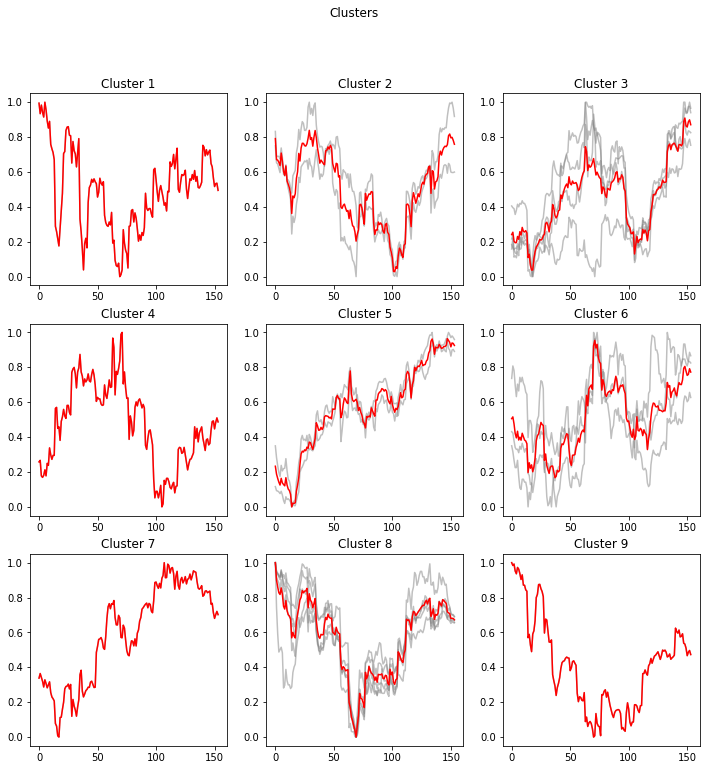

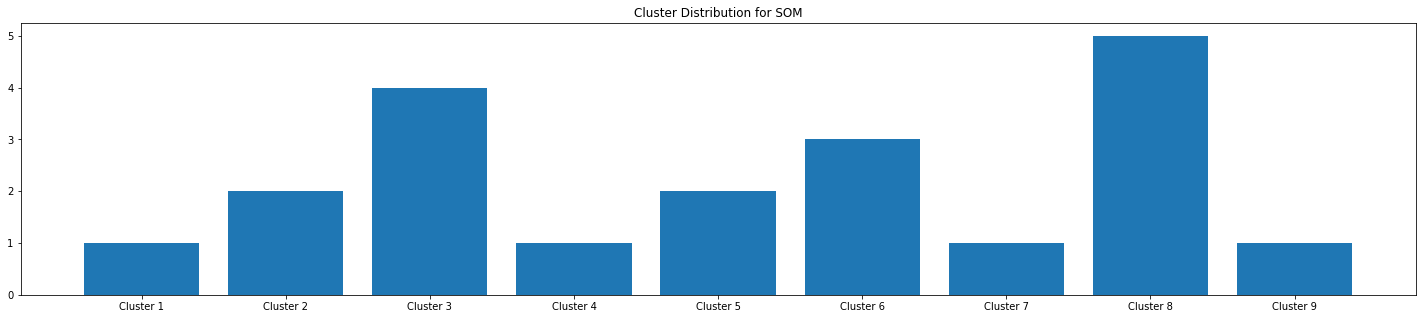

In [ ]:
# Visualization
visualize_clusters(som_x, som_y, win_map)

In [ ]:
# Correlation Matrix
# import seaborn as sns

# corr_matrix = clusters.corr()
# corr_matrix.style.background_gradient(cmap='coolwarm')

In [ ]:
# Remove clusters 8 and 9
# clusters = clusters.loc[clusters['Cluster']!='Cluster 1']
# clusters = clusters.loc[clusters['Cluster']!='Cluster 5']
# clusters = clusters.loc[clusters['Cluster']!='Cluster 7']
# clusters

In [ ]:
series_clusters = []
for i in range(1, 8):
    series_clusters.append(clusters.loc[clusters['Cluster'] == f'Cluster {i}'].index.to_list())

In [ ]:
series_clusters = list(filter(None, series_clusters))
series_clusters

[['HBAN'],
 ['AAPL', 'UBER'],
 ['ITUB', 'CTRA', 'VALE', 'MRO'],
 ['CDEV'],
 ['COST', 'CLF'],
 ['SLB', 'SIRI', 'KGC'],
 ['WMT']]

In [ ]:
# Remove the stocks that are not in the profitable stocks 

prof_series = []

for lst in series_clusters:
    for ticker in lst:
        if ticker not in prof_stocks:
            lst.remove(ticker)
    prof_series.append(lst)
    
prof_series

[['HBAN'],
 ['AAPL', 'UBER'],
 ['ITUB', 'CTRA', 'VALE', 'MRO'],
 ['CDEV'],
 ['COST', 'CLF'],
 ['SLB', 'SIRI', 'KGC'],
 ['WMT']]

In [ ]:
# prof_series = series_clusters

for lst in prof_series:
    if len(lst) < 2:
        prof_series.remove(lst)

prof_series

[['AAPL', 'UBER'],
 ['ITUB', 'CTRA', 'VALE', 'MRO'],
 ['COST', 'CLF'],
 ['SLB', 'SIRI', 'KGC']]

## Selection based on Rewards

In [ ]:
# Get list of Date
df = pd.read_csv(f'./datasets/AAPLday.csv')
df = df[(df['Date'] >= '2022-02-22') & (df['Date'] <= '2022-03-23')]
Date = df['Date'].to_list()

portfolio = {}
for date in Date:
    portfo = [] # list of best stocks of each cluster
    for lst in prof_series:
        max_rew = 0 # maximum reward among all stocks of each cluster
        max_ticker = None # the ticker with the highest return
        for ticker in lst:
            if ticker not in daily_prof_stocks_DQN[date]:
                continue
            reg_pred = pd.read_csv(f"./Output/results/Regression models predictions/{ticker}_lsgr_True.csv")
            reg_pred = reg_pred[reg_pred['Date'] == date]
            reg_pred.reset_index(drop=True, inplace=True)
            if reg_pred['Reward'][0] > max_rew:
                max_rew = reg_pred['Reward'][0]
                max_ticker = ticker
        if max_ticker != None:
            portfo.append([max_ticker, round(max_rew, 2)])
    portfolio[date] = portfo


In [ ]:
portfolio

{'2022-02-22': [],
 '2022-02-23': [],
 '2022-02-24': [],
 '2022-02-25': [],
 '2022-02-28': [],
 '2022-03-01': [['UBER', 0.01], ['CTRA', 0.01]],
 '2022-03-02': [['ITUB', 0.02], ['KGC', 0.33]],
 '2022-03-03': [['SLB', 0.02]],
 '2022-03-04': [['CTRA', 0.01], ['COST', 0.02], ['SIRI', 0.02]],
 '2022-03-07': [['UBER', 0.05], ['COST', 0.02], ['SIRI', 0.02]],
 '2022-03-08': [['UBER', 0.09], ['ITUB', 0.02]],
 '2022-03-09': [['AAPL', 0.02], ['VALE', 0.03], ['COST', 0.04]],
 '2022-03-10': [['UBER', 0.02], ['ITUB', 0.01], ['SLB', 0.02]],
 '2022-03-11': [['UBER', 0.01]],
 '2022-03-14': [['UBER', 0.02]],
 '2022-03-15': [['UBER', 0.08], ['MRO', 0.02], ['KGC', 0.03]],
 '2022-03-16': [['UBER', 0.06]],
 '2022-03-17': [['VALE', 0.01]],
 '2022-03-18': [['ITUB', 0.01], ['SLB', 0.02]],
 '2022-03-21': [['MRO', 0.01], ['SLB', 0.02]],
 '2022-03-22': [],
 '2022-03-23': [['MRO', 0.02], ['SLB', 0.03]]}

In [ ]:
# Normalize weights

for date, lst in portfolio.items():
    rewards = []
    norm_rewards = []
    tickers = []
    sum = 0
    for sublst in lst:
        tickers.append(sublst[0])
        rewards.append(sublst[1])
        sum += sublst[1]
    
    for i in rewards:
        norm_rew = round((i / sum), 2)
        norm_rewards.append(norm_rew)
    
    portfolio[date] = list(zip(tickers, norm_rewards))


In [ ]:
portfolio

{'2022-02-22': [],
 '2022-02-23': [],
 '2022-02-24': [],
 '2022-02-25': [],
 '2022-02-28': [],
 '2022-03-01': [('UBER', 0.5), ('CTRA', 0.5)],
 '2022-03-02': [('ITUB', 0.06), ('KGC', 0.94)],
 '2022-03-03': [('SLB', 1.0)],
 '2022-03-04': [('CTRA', 0.2), ('COST', 0.4), ('SIRI', 0.4)],
 '2022-03-07': [('UBER', 0.56), ('COST', 0.22), ('SIRI', 0.22)],
 '2022-03-08': [('UBER', 0.82), ('ITUB', 0.18)],
 '2022-03-09': [('AAPL', 0.22), ('VALE', 0.33), ('COST', 0.44)],
 '2022-03-10': [('UBER', 0.4), ('ITUB', 0.2), ('SLB', 0.4)],
 '2022-03-11': [('UBER', 1.0)],
 '2022-03-14': [('UBER', 1.0)],
 '2022-03-15': [('UBER', 0.62), ('MRO', 0.15), ('KGC', 0.23)],
 '2022-03-16': [('UBER', 1.0)],
 '2022-03-17': [('VALE', 1.0)],
 '2022-03-18': [('ITUB', 0.33), ('SLB', 0.67)],
 '2022-03-21': [('MRO', 0.33), ('SLB', 0.67)],
 '2022-03-22': [],
 '2022-03-23': [('MRO', 0.4), ('SLB', 0.6)]}

# Trading

In [ ]:
from Trading_Metrics import *

returns = {}
total_ret = 0
initial_capital = 1e6


for date, portfo in portfolio.items():
    ret = 0

    if not portfo: # list is empty
         returns[date] = initial_capital
         continue

    for item in portfo:
        ticker = item[0]
        weight = item[1]
        capital = weight * initial_capital
        df = pd.read_csv(f"./datasets/{ticker}day.csv")
        ret += trade(df, date, capital, long=True)
    
    # Save the daily return
    returns[date] = round(ret, 2)
    initial_capital = round(ret, 2)

returns

{'2022-02-22': 1000000.0,
 '2022-02-23': 1000000.0,
 '2022-02-24': 1000000.0,
 '2022-02-25': 1000000.0,
 '2022-02-28': 1000000.0,
 '2022-03-01': 992355.27,
 '2022-03-02': 1057750.75,
 '2022-03-03': 1054738.76,
 '2022-03-04': 1069134.97,
 '2022-03-07': 1025261.98,
 '2022-03-08': 1091021.14,
 '2022-03-09': 1082323.27,
 '2022-03-10': 1085298.09,
 '2022-03-11': 1066574.13,
 '2022-03-14': 1023225.99,
 '2022-03-15': 1043333.28,
 '2022-03-16': 1114415.27,
 '2022-03-17': 1141894.05,
 '2022-03-18': 1153189.15,
 '2022-03-21': 1183898.19,
 '2022-03-22': 1183898.19,
 '2022-03-23': 1194029.94}

In [ ]:
# Create a DataFrame for portfolio evaluation
dates = list(returns.keys())
capitals = list(returns.values())
df = pd.DataFrame({'Date':dates,'Capital':capitals})
# df.to_csv("Output/results/Portfolio/returns_ensemble.csv")
df

,Date,Capital
0,2022-02-22,1000000.00
1,2022-02-23,1000000.00
2,2022-02-24,1000000.00
3,2022-02-25,1000000.00
4,2022-02-28,1000000.00
5,2022-03-01,992355.27
6,2022-03-02,1057750.75
7,2022-03-03,1054738.76
8,2022-03-04,1069134.97
9,2022-03-07,1025261.98


In [ ]:
from Trading_Metrics import *
# Calculate Metrics
initial_capital = 1e6
portfo_metrics = metrics(df, initial_capital)
portfo_metrics.to_csv("Output/results/Portfolio/PortfolioMetrics_3act.csv")
portfo_metrics

Sortino Ratio = nan 

Sharpe Ratio = 2.9311357770290036 

MDD = 20.17 



,Date,Capital,Return,ROR,DD,RRR
0,2022-02-22,1000000.00,0.00,0.000000,19.402994,0.000000
1,2022-02-23,1000000.00,0.00,0.000000,19.402994,0.000000
2,2022-02-24,1000000.00,0.00,0.000000,19.402994,0.000000
3,2022-02-25,1000000.00,0.00,0.000000,19.402994,0.000000
4,2022-02-28,1000000.00,0.00,0.000000,19.402994,0.000000
5,2022-03-01,992355.27,-7644.73,-0.764473,20.167467,-3.790149
6,2022-03-02,1057750.75,57750.75,5.775075,13.627919,28.632003
7,2022-03-03,1054738.76,54738.76,5.473876,13.929118,27.138701
8,2022-03-04,1069134.97,69134.97,6.913497,12.489497,34.276138
9,2022-03-07,1025261.98,25261.98,2.526198,16.876796,12.524531


In [ ]:
# Buy and hold 
from Trading_Metrics import *

portfo = [('CTRA', 0.5), ('UBER', 0.5)]
start = '2022-03-01'
end = '2022-03-23'
initial_capital = 1e6

bh_returns = buy_and_hold(portfo, start, end, initial_capital)
bh_returns

{'2022-03-01': 1000000.0,
 '2022-03-02': 1029101.3946554642,
 '2022-03-03': 991588.9154112481,
 '2022-03-04': 976019.8707099258,
 '2022-03-07': 975697.9514603552,
 '2022-03-08': 987393.1050844775,
 '2022-03-09': 987316.834221669,
 '2022-03-10': 989092.5513634018,
 '2022-03-11': 979888.4908152749,
 '2022-03-14': 906591.9803750315,
 '2022-03-15': 920569.0370661464,
 '2022-03-16': 962847.7128840395,
 '2022-03-17': 992455.8811670218,
 '2022-03-18': 1002238.0684265676,
 '2022-03-21': 990704.0143177235,
 '2022-03-22': 1017074.0706279583,
 '2022-03-23': 1025316.1027454126}

In [ ]:
# Create a DataFrame for portfolio evaluation
dates = list(bh_returns.keys())
capitals = list(bh_returns.values())
df = pd.DataFrame({'Date':dates,'Capital':capitals})
df.to_csv("Output/results/Portfolio/returns_3act.csv")
df

,Date,Capital
0,2022-03-01,1.000000e+06
1,2022-03-02,1.029101e+06
2,2022-03-03,9.915889e+05
3,2022-03-04,9.760199e+05
4,2022-03-07,9.756980e+05
5,2022-03-08,9.873931e+05
6,2022-03-09,9.873168e+05
7,2022-03-10,9.890926e+05
8,2022-03-11,9.798885e+05
9,2022-03-14,9.065920e+05


In [ ]:
from Trading_Metrics import *
# Calculate Metrics
initial_capital = 1e6
portfo_metrics = metrics(df, initial_capital)
portfo_metrics.to_csv("Output/results/Portfolio/PortfolioMetrics_bh.csv")
portfo_metrics

Sortino Ratio = 0.8843869164571926 

Sharpe Ratio = 0.7942236544545149 

MDD = 12.25 



,Date,Capital,Return,ROR,DD,RRR
0,2022-03-01,1.000000e+06,0.000000,0.000000,2.910139,0.000000
1,2022-03-02,1.029101e+06,29101.394655,2.910139,0.000000,23.756241
2,2022-03-03,9.915889e+05,-8411.084589,-0.841108,3.751248,-6.866192
3,2022-03-04,9.760199e+05,-23980.129290,-2.398013,5.308152,-19.575616
4,2022-03-07,9.756980e+05,-24302.048540,-2.430205,5.340344,-19.838407
5,2022-03-08,9.873931e+05,-12606.894916,-1.260689,4.170829,-10.291343
6,2022-03-09,9.873168e+05,-12683.165778,-1.268317,4.178456,-10.353605
7,2022-03-10,9.890926e+05,-10907.448637,-1.090745,4.000884,-8.904040
8,2022-03-11,9.798885e+05,-20111.509185,-2.011151,4.921290,-16.417559
9,2022-03-14,9.065920e+05,-93408.019625,-9.340802,12.250941,-76.251445


In [ ]:
df = pd.read_csv(f"./datasets/{ticker}day.csv")
start_price = df[df['Date'] == start]
start_price

,Unnamed: 0,Date,Time,Datetime,Open,High,Low,Close,Adj Close,Volume


# Visualization of the results

In [ ]:
from visualization import *
import pandas as pd

## DQN

In [ ]:
# Number of stocks with positive and negative returns
# Ensemble approach
df = pd.read_csv(f"./Output/results/DQN metrics/Final results/ensemble_metrics_test.csv")
rewards = df['Reward_Long%'].to_list()
pos_rewards = 0
neg_rewards = 0
for rew in rewards:
    if rew >= 0:
        pos_rewards += 1
    else:
        neg_rewards +=1

pos_rewards_percentage = pos_rewards / len(rewards) * 100
neg_rewards_percentage = neg_rewards / len(rewards) * 100

# Pie chart of positive and negative rewards
pie_chart(['Positive Returns', 'Negative Returns'], [pos_rewards_percentage, neg_rewards_percentage])

In [ ]:
# Number of stocks with positive and negative returns
# 3act approach
df = pd.read_csv(f"./Output/results/DQN metrics/Final results/3act_metrics_test.csv")
rewards = df['Reward_Long%'].to_list()
pos_rewards = 0
neg_rewards = 0
for rew in rewards:
    if rew >= 0:
        pos_rewards += 1
    else:
        neg_rewards +=1

pos_rewards_percentage = pos_rewards / len(rewards) * 100
neg_rewards_percentage = neg_rewards / len(rewards) * 100

# Pie chart of positive and negative rewards
pie_chart(['Positive Returns', 'Negative Returns'], [pos_rewards_percentage, neg_rewards_percentage])

## Return predictions

In [ ]:
# bar plot of predicted returns and true returns
df_preds = pd.read_csv(f"./Output/results/Regression models predictions/GOOGL_lsgr_True.csv")
df = pd.read_csv(f"./datasets/GOOGLday.csv")
dates = df_preds['Date'].to_list()
preds = df_preds['Reward'].to_list()
true_returns = []
for i, date in enumerate(dates):
    local_df = df[df['Date'] == date]
    open = float(local_df['Open'].values)
    close = float(local_df['Close'].values)
    ret = (close - open) / open
    if ret < 0: ret = 0
    true_returns.append(ret)

bar_plot(true_returns, preds, dates, ['True returns', 'predicted returns'], "GOOGL stock")

## portfolio 

In [ ]:
returns = portfo_metrics['Return'].to_list()
dates = portfo_metrics['Date'].to_list()
line_chart(returns, dates)

In [ ]:

pie_chart(['GOOGL', 'AAPL', 'CTRA', 'SLB'], [25, 25, 12.5, 37.5])

In [ ]:
import plotly.express as px

# Plot Cumulative Returns


# Get list of Date
df = pd.read_csv(f'./datasets/AAPLday.csv')
df = df[(df['Date'] >= '2022-03-01') & (df['Date'] <= '2022-03-23')]
Date = df['Date'].to_list()

# Read results
ensemble = pd.read_csv(f"./Output/results/Portfolio/PortfolioMetrics_ensemble.csv")
three_act = pd.read_csv(f"./Output/results/Portfolio/PortfolioMetrics_3act.csv")
bh = pd.read_csv(f"./Output/results/Portfolio/PortfolioMetrics_bh.csv")

ens_ret = ensemble['Return'][5:].to_list()
three_act_ret = three_act['Return'][5:].to_list()
bh_ret = bh['Return'].to_list()

data = {
    'Date' : Date,
    '3action approach' : three_act_ret,
    'Ensemble approach': ens_ret,
    'Buy and Hold': bh_ret
}

df = pd.DataFrame(data)

# fig = px.line(df, x='date', y="3action approach")
fig = px.line(df, x='Date', y=df.columns[1:])
# fig.add_scatter(x=df['date'], y=df['Ensemble approach'], mode='lines')
# fig.add_scatter(x=df['date'], y=df['Buy and Hold'], mode='lines')

fig.show()







